# 0. Introduction

## Goal

This notebook aims to present how data stored in non formatted documents could be leveraged to improve data quality inside the PIM.

This notebook uses a handful of modules developped inside this project.

## What pipeline?

The different steps for this project are as follows:

1. fetch all product IDs from PIM with the associated ingredient lists
- split the products between a train set and a test set
- train the algorithm on the train set: i.e. construct the vocabulary
- make it make prediction on the test set
- compare it with the ingredient list on this product

# 1. Fetching the data

We will use production data for training and testing of this model. The ID of the products are the PIM uid, and therefore are listed in the directory of the PIM-API module.

First, let's get those uids.

In [1]:
from src import pimapi
requester = pimapi.Requester('prd')
requester.refresh_directory()
requester._directory

Done


,type,title,lastModified,lastRefreshed,lastFetchedData,lastFetchedFiles
uid,,,,,,
58f67e91-6d16-4f12-97c7-e67d24be6805,pomProduct,Curcuma moulu en sac 1 kg LA CASE AUX EPICES,2019-12-06 11:24:21.231000+00:00,2020-02-05 08:19:08.057066+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
f46327cf-8f3c-4b67-85fa-7e6e6daaf618,pomProduct,Pique à viande bleu en sachet de 100 HIPPOPOTAMUS,2020-01-06 14:52:29.288000+00:00,2020-02-05 08:19:08.057066+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
58a1ae66-ca4d-4d82-9d30-4073b1edaeb8,pomProduct,Pique à viande rouge en sachet de 100 HIPPOPOT...,2020-01-06 14:52:48.715000+00:00,2020-02-05 08:19:08.057066+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
9bc59474-7839-458b-b56a-ba334fe4894b,pomProduct,Pique à viande noir en sachet de 100 HIPPOPOTAMUS,2020-01-06 14:53:00.627000+00:00,2020-02-05 08:19:08.057066+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
c97834e7-124e-4491-9f2a-3e4009fdda4e,pomProduct,Pique à viande marron en sachet de 100 HIPPOPO...,2020-01-06 14:53:12.375000+00:00,2020-02-05 08:19:08.057066+00:00,2020-02-03 13:22:18.211934+00:00,2020-02-03 13:22:48.460434+00:00
...,...,...,...,...,...,...
b193702d-848a-4ed6-9d5f-0ba20ad17617,pomProduct,VELOUTE POIREAUX PDT INST. SAC 40 RAT,2020-02-04 15:30:32.232000+00:00,2020-02-05 08:19:08.057066+00:00,NaT,NaT
cb59e249-a827-403f-97ac-22f90a80c7fc,pomProduct,CONF. FRAISE POT 320G 45% FRSE 15%POM LG,2020-02-04 20:36:43.860000+00:00,2020-02-05 08:19:08.057066+00:00,NaT,NaT
a1aceea1-7399-4577-a335-da3d29e3650c,pomProduct,CONF FRAISE BIO BCL 320G LG,2020-02-04 20:39:08.345000+00:00,2020-02-05 08:19:08.057066+00:00,NaT,NaT


One can see the modification status of the product via the `modification_report` method:

In [10]:
requester.modification_report()

Number of items: 12868
Number of items with outdated data: 0
Number of items with outdated files: 0


Outdated products can be refreshed via the following:

In [9]:
requester.fetch_list_from_PIM(requester.modified_items())
requester.dump_data_from_result()
requester.dump_files_from_result()
requester.modification_report()

Done
Done
Launching 5 threads.
Thread complete!
Thread complete!
Thread complete!
Thread complete!
Thread complete!
Done


The PIM uids of the products are the keys of the `directory` of our requester. We extract the ingredients associated with these uids.

In [11]:
requester.fetch_all_from_PIM(page_size=1000, max_page=-1, nx_properties='*')
requester.result[0].json()['entries'][0]

Done


{'entity-type': 'document',
 'repository': 'default',
 'uid': 'a2f4eef0-5228-44ad-9c54-46a6286a150f',
 'path': '/default-domain/pomSupplierWorkspace/SANIPOUSSE/Gant_anti-chaleur_en_pur_silicone_liquide_LSR_SANIPOUSSE',
 'type': 'pomProduct',
 'state': 'product.waiting.supplier.validation',
 'parentRef': 'a1558491-11d8-4d38-a66c-a777bedf7ca9',
 'isCheckedOut': False,
 'isVersion': False,
 'isProxy': False,
 'changeToken': '22-0',
 'isTrashed': False,
 'title': 'Gant anti-chaleur en pur silicone liquide LSR SANIPOUSSE',
 'lastModified': '2019-12-06T11:39:43.920Z',
 'properties': {'pprodc:ingredientsList': None,
  'pprodc:withoutPalmOil': None,
  'pprodc:withoutEDTA': None,
  'pprodc:withoutAdditive': None,
  'pprodc:eggFarmingMode': None,
  'pprodc:monoIngredient': False,
  'pprodc:withoutChlorine': None,
  'pprodc:activeIngredients': [],
  'pprodc:mainIngredients': [],
  'pprodc:withoutCornStarch': None,
  'pprodc:withoutPhthalate': None,
  'pprodc:eggOrigin': [],
  'pprodc:withoutPolyp

In [12]:
mapping = {'uid': 'uid', 'Libellé': 'title', 'Ingrédients': 'properties.pprodc:ingredientsList'}
df = requester.result_to_dataframe(record_path='entries', mapping=mapping, index='uid')
df

,Libellé,Ingrédients
uid,,
a2f4eef0-5228-44ad-9c54-46a6286a150f,Gant anti-chaleur en pur silicone liquide LSR ...,None
f961877c-6104-4e67-ae06-cfe1b1a6d57b,Infusion verveine-menthe en boîte de 20 SAGY,60% Verveine / 40% Menthe
c8c80df8-a300-4f6f-a2cd-27450e151625,Pâte à tartiner spéculoos en pot 720 g LOTUS,"Original speculoos 58% (farine de BLE, sucre, ..."
868b344a-3ad0-44da-81c9-a587a740c7ae,Pays d'Oc Cabernet-Sauvignon IGP en bouteille ...,None
d118e21c-f928-411d-8827-bf9f3b4ec2e4,Pays d'Oc Sauvignon blanc IGP en bouteille 75 ...,Contient des SULFITES
...,...,...
390b2ea1-ffb6-4871-88ca-89cfd4cb6184,Ail fumé en semoule en boîte 300 g DUCROS,"Ail déshydraté (99%), arôme de fumée, arôme (c..."
343ba524-393f-4e72-834b-f2cb7cdaf0d9,Paprika fumé en boîte 230 g DUCROS,Paprika fumé (10%)
550758b8-b60c-441d-a5b1-63c21788cd02,BOISSON FERMENTÉE DÉSALCOOLISÉE À BASE DE RAIS...,"Vin rosé désalcoolisé, sucre de raisin, arômes..."


# 2. Train / Test split

We will separate our data into a train test and a test set of equal sizes.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.5, random_state=42)

In [14]:
print(len(X_train))
X_train.iloc[:10]

6434


,Libellé,Ingrédients
uid,,
e71bc6ec-cf35-44c2-9d4f-a014d971a9f7,Sirop de menthe verte en bouteille 1 L TAIGA,"Sirop de glucose-fructose, eau, sucre, arôme n..."
a504973b-65f6-4802-bd98-232f5dbcf164,Sauce tomate oignon en brique 2 kg BARILLA,"Pulpe de tomates 68,6%, concentré de tomates, ..."
72cb7546-b750-4aab-bd1f-6563c39ac6c4,Carambar Magicolor en boîte de 200 CARAMBAR,"Sirop de glucose, sucre, huile de palme, arôme..."
09fbd113-6fab-447f-aa14-7a9b538c00ae,Mammouth Tétine Pica Color en boîte de 80 BRABO,"Dextrose, sucre, gomme base, sirop de glucose,..."
52255df2-5e63-4ae9-a321-b58de077a9ef,"Mini coupelle ronde 3,6 g PIDY",INGREDIENTS : Farine de BLE enrichie (farine d...
f9e850f0-45b8-49f6-949c-6a641a1a05cd,Compote pomme-cassis allégée en coupelle 100 g...,"Pommes 88%, cassis 8%, sucre, jus concentré de..."
845d96a4-096c-47d8-b578-c5f5ea354d7e,COQUILLETTE QS 5 KG EPISAVEURS,"Semoule de BLÉ dur de qualité supérieure, peut..."
bb9e1f71-149f-4c7d-8f60-ff4c69171a5e,Mélange 4 épices en sachet 1 kg LA CASE AUX EP...,"Cannelle, girofle, muscade, poivre"
d918a73e-1a52-4058-84cb-22543c70b9e4,Croûtons cubes nature en sachet 500 g TIPIAK,"Farine de BLE, huile de tournesol, huile de pa..."


In [15]:
print(len(X_test))
X_test.iloc[:10]

6434


,Libellé,Ingrédients
uid,,
77706aef-e30a-4342-ad64-22aa1d2882c3,#Couverc pot plst crist sac (100U)x30 AF,None
86eece02-ff01-42b2-8aa1-6f24e72a9ff2,Sauce vinaigrette balsamique de Modène fraise ...,"Ingrédients : huile de tournesol, Aceto Balsam..."
0ec80e78-db52-492c-815c-2443f8977823,BARQUETTE EN ALUMINIUM 0.25L 129X86X38MM,None
5f00bfd3-150e-4ba0-918d-668ba382a65d,SCIURE DE BOIS EN SAC 15 KG SICSA B5/10,None
ac3348da-e58d-40c0-972c-204a52c04963,Velouté de bolet très faible en sodium en sach...,Farine de BLE - Amidon de maïs - Matières gras...
abf01f16-816f-4330-abb1-30c36983d8ac,SPÉCIALITÉ DE LAIT DE COCO MANGUES 95 G CHARLE...,"Lait de noix de coco allégé 50% (eau, extrait ..."
0c809e3b-c940-468b-bb0a-1a0a556d2f1b,SAC 5KG POLENTA BIO SABAROT,100% polenta issu de l’agriculture biologique
c9be1b25-0ff6-4ce8-9131-49fbd4e35019,ARIZONA PET 500ML JUS FRAISE CITRON CARTON DE ...,"eau, jus de fruits à base de concentrés 7% (ci..."
8d9b3bde-6a1c-41f5-8d04-a33f17c16346,DECOR EN AZYME : FEUILLE DE ROSE 38 MM VERT CLAIR,Amidon de maïs. fécule de pomme de terre. Colo...


# 3. Constructing the vocabulary

We will now use bag-of-words related functionalities of scikit-learn to construct our vocabulary.

## 3.1 Removing `None` values

First step is to remove `None` values from ingredient lists to make our count of words.

In [16]:
import pandas as pd
print(f'None values before replacement in X_train: {sum(pd.isna(X_train["Ingrédients"]))}')
X_train.loc[:, 'Ingrédients'].fillna('', inplace=True)
print(f'None values after replacement in X_train: {sum(pd.isna(X_train["Ingrédients"]))}')
print(f'None values before replacement in X_test: {sum(pd.isna(X_test["Ingrédients"]))}')
X_test.loc[:, 'Ingrédients'].fillna('', inplace=True)
print(f'None values after replacement in X_train: {sum(pd.isna(X_test["Ingrédients"]))}')

None values before replacement in X_train: 1686
None values after replacement in X_train: 0
None values before replacement in X_test: 1688
None values after replacement in X_train: 0


C:\Users\pmasse\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## 3.2 Parsing the corpus

We now parse our ingredient lists, with a naive approach (no stop words, no preprocessing, ...).

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.loc[:, 'Ingrédients'])

We can see that we know have a matrix with as much rows as the number of products in our train corpus, and as much columns as the number of different words in their ingredient lists.

In [18]:
X_train_counts.shape

(6434, 3140)

The vocabulary has been computed: 

In [19]:
print(f'The vocabulary length is {len(count_vect.vocabulary_)}')
count_vect.vocabulary_

The vocabulary length is 3140


{'sirop': 2697,
 'de': 1057,
 'glucose': 1602,
 'fructose': 1537,
 'eau': 1344,
 'sucre': 2768,
 'arôme': 459,
 'naturel': 2123,
 'menthe': 2002,
 'colorants': 876,
 'e102': 1181,
 'e131': 1190,
 'pulpe': 2467,
 'tomates': 2868,
 '68': 217,
 'concentré': 904,
 'oignon': 2192,
 'carotte': 732,
 'huile': 1715,
 'tournesol': 2891,
 'sel': 2674,
 'poivre': 2357,
 'ail': 338,
 'thym': 2850,
 'persil': 2303,
 'ciboulette': 831,
 'palme': 2243,
 'arômes': 460,
 'acidifiant': 286,
 'acide': 277,
 'citrique': 842,
 'gélatine': 1681,
 'émulsifiants': 3095,
 'e471': 1297,
 'lécithine': 1918,
 'colorant': 873,
 'e133': 1192,
 'dextrose': 1085,
 'gomme': 1625,
 'base': 526,
 'acidifiants': 287,
 'malique': 1945,
 'aromes': 452,
 'glycerine': 1609,
 'amidon': 381,
 'modifie': 2040,
 'e120': 1185,
 'e141': 1194,
 'e160e': 1214,
 'e171': 1219,
 'antioxydant': 417,
 'e321': 1246,
 'ingredients': 1756,
 'farine': 1442,
 'ble': 582,
 'enrichie': 1371,
 'gluten': 1608,
 'orge': 2217,
 'malté': 1956,
 'nia

We can print out the top 10 most frequent words in our ingredient lists:

In [20]:
word_counts = X_train_counts.sum(axis=0)
word_counts2 = [(word, word_counts[0, idx]) for word, idx in count_vect.vocabulary_.items()]
word_counts2.sort(key=lambda x: x[1], reverse=True)
word_counts = word_counts2
word_counts[:10]

[('de', 14611),
 ('sucre', 2906),
 ('sel', 2250),
 ('acide', 1885),
 ('eau', 1793),
 ('lait', 1577),
 ('poudre', 1485),
 ('huile', 1428),
 ('arôme', 1331),
 ('sirop', 1233)]

# 4. First analysis of a single document

## 4.1 Parsing a doc from the test set

First, we use a function that parses a document from the disk from its product uid and returns a list of strings. For illustration, we choose one of the products in our test set.

In [21]:
X_test.iloc[:10]

,Libellé,Ingrédients
uid,,
77706aef-e30a-4342-ad64-22aa1d2882c3,#Couverc pot plst crist sac (100U)x30 AF,
86eece02-ff01-42b2-8aa1-6f24e72a9ff2,Sauce vinaigrette balsamique de Modène fraise ...,"Ingrédients : huile de tournesol, Aceto Balsam..."
0ec80e78-db52-492c-815c-2443f8977823,BARQUETTE EN ALUMINIUM 0.25L 129X86X38MM,
5f00bfd3-150e-4ba0-918d-668ba382a65d,SCIURE DE BOIS EN SAC 15 KG SICSA B5/10,
ac3348da-e58d-40c0-972c-204a52c04963,Velouté de bolet très faible en sodium en sach...,Farine de BLE - Amidon de maïs - Matières gras...
abf01f16-816f-4330-abb1-30c36983d8ac,SPÉCIALITÉ DE LAIT DE COCO MANGUES 95 G CHARLE...,"Lait de noix de coco allégé 50% (eau, extrait ..."
0c809e3b-c940-468b-bb0a-1a0a556d2f1b,SAC 5KG POLENTA BIO SABAROT,100% polenta issu de l’agriculture biologique
c9be1b25-0ff6-4ce8-9131-49fbd4e35019,ARIZONA PET 500ML JUS FRAISE CITRON CARTON DE ...,"eau, jus de fruits à base de concentrés 7% (ci..."
8d9b3bde-6a1c-41f5-8d04-a33f17c16346,DECOR EN AZYME : FEUILLE DE ROSE 38 MM VERT CLAIR,Amidon de maïs. fécule de pomme de terre. Colo...


In [22]:
from src.pimpdf import PDFDecoder
import os

# This uid has been gotten from the previous cell, maybe from a previous run!
uid = '776613db-a461-44e1-ab6a-1344ac6ae99c'
test_doc_blocks = PDFDecoder.path_to_blocks(os.path.join('.', 'dumps', 'prd', uid, 'FTF.pdf'))
print(f'Number of blocks in this document: {len(test_doc_blocks)}')
test_doc_blocks

Number of blocks in this document: 42


['FICHE DE SPECIFICATIONS',
 "DELIR' PIK (avec violet)",
 'ANNEXE 02207B\ndate:10/06/2015',
 'HACCP',
 "Définition et procédé d'obtention :",
 "Assortiment d'articles de confiserie, gélifiés, souples, colorés, pour certains composés de deux couches (une \ntranslucide colorée et une opaque blanche), enrobés de sucre acidifié, obtenus par la technique de coulée d'un sirop \nrésultant de la dissolution de sucres et gélatine (foisonné pour la couche opaque) dans des empreintes d'amidon natif \nde maïs leur conférant des formes originales qui après gélification et séchage, sont démoulés, dépoudrés et enrobés \nde sucre acidifié.",
 'Dénomination :',
 'confiserie gélifiée acidifiée',
 'Composition :',
 "Ingrédients:  sirop de glucose; sucre; gélatine; dextrose; acidifiants: acide citrique, acide malique; agent d'enrobage: \ncire de carnauba; correcteurs d'acidité: citrate tricalcique, malate acide de sodium; arôme; concentrés de fruits et de \nplantes: citron, carthame, spiruline, patate dou

For this specific document (*776613db-a461-44e1-ab6a-1344ac6ae99c*), the correct block of text is:

    Ingrédients:  sirop de glucose; sucre; gélatine; dextrose; acidifiants: acide citrique, acide malique; agent d'enrobage: cire de carnauba; correcteurs d'acidité: citrate tricalcique, malate acide de sodium; arôme; concentrés de fruits et de plantes: citron, carthame, spiruline, patate douce, radis; sirop de sucre inverti; colorants: carmins, bleu patenté V, carotènes végétaux, lutéine, anthocyanes.

The index of this correct block is *9* in our block list.

In [23]:
true_idx = 9

We will now parse these blocks with the vocabulary computed from our train set. We reuse the `CountVectorizer` we trained before, but take care just to use the `transform` method.

Using the `fit_transform` method would retrain the model with the current blocks of text.

In [24]:
test_doc_counts = count_vect.transform(test_doc_blocks)
test_doc_counts

<42x3140 sparse matrix of type '<class 'numpy.int64'>'
	with 156 stored elements in Compressed Sparse Row format>

## 4.2 Getting some insights from this first analysis

We can compute and draw the terms counts for our blocks: 

In [25]:
import numpy as np

term_counts = np.ravel(test_doc_counts.sum(axis=1))
term_counts

array([ 1,  2,  2,  0,  1, 40,  0,  3,  1, 50,  0,  0, 10,  1,  2,  3,  0,
        2,  2,  0,  0,  5,  2,  2,  1,  2,  0,  2,  3,  0,  1,  5, 12,  3,
        0,  3,  5,  1, 15,  2, 11,  0], dtype=int64)

We can see that the *true* ingredient list has the higher term_count. However, term counts alone are likely to have a biais toward long blocks, so we can also compute a term frequency.

We will instantiate a new count_vectorizer, for the sole purpose of counting tokens in the blocks.

In [26]:
blocks_word_counts = np.ravel(CountVectorizer().fit_transform(test_doc_blocks).todense().sum(axis=1))
blocks_word_counts

array([ 3,  4,  6,  1,  4, 70,  1,  3,  1, 50,  3,  1, 14,  5,  2,  4,  1,
        2,  2,  2,  4,  5,  2,  2,  2,  3,  4,  6,  8,  0,  1, 10, 22, 10,
        1,  8, 17,  2, 20,  3, 20,  0], dtype=int64)

We can now compute the frequencies of "ingredient words" in the blocks of this document.

In [27]:
term_freqs = np.divide(term_counts, blocks_word_counts, where=blocks_word_counts!=0)
term_freqs

array([3.33333333e-001, 5.00000000e-001, 3.33333333e-001, 0.00000000e+000,
       2.50000000e-001, 5.71428571e-001, 0.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       7.14285714e-001, 2.00000000e-001, 1.00000000e+000, 7.50000000e-001,
       0.00000000e+000, 1.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       5.00000000e-001, 6.66666667e-001, 0.00000000e+000, 3.33333333e-001,
       3.75000000e-001, 2.44029516e-312, 1.00000000e+000, 5.00000000e-001,
       5.45454545e-001, 3.00000000e-001, 0.00000000e+000, 3.75000000e-001,
       2.94117647e-001, 5.00000000e-001, 7.50000000e-001, 6.66666667e-001,
       5.50000000e-001, 5.68175493e-322])

C:\Users\pmasse\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\pmasse\AppData\Local\Continuum\anaconda3\envs\py3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


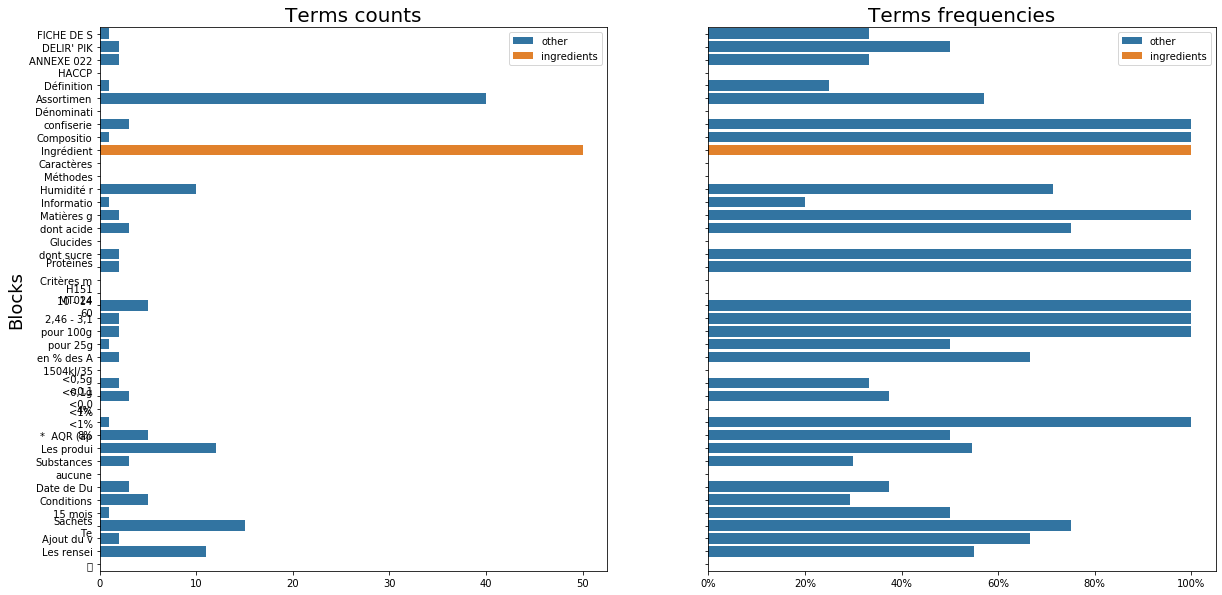

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

colors = ['other'] * len(test_doc_blocks)
colors[true_idx] = 'ingredients'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
sns.barplot(ax=ax[0], x=term_counts, y=[block[:10] for block in test_doc_blocks], hue=colors, dodge=False)
sns.barplot(ax=ax[1], x=term_freqs, y=[block[:10] for block in test_doc_blocks], hue=colors, dodge=False)
ax[0].set_title('Terms counts', fontsize=20)
ax[0].set_ylabel('Blocks', fontsize=18)
ax[1].set_title('Terms frequencies', fontsize=20)
ax[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
pass

We can see that some very short texts also have an "ingredient word frequency" equal to 100%.

We can draw a scatter plot of these indicators:

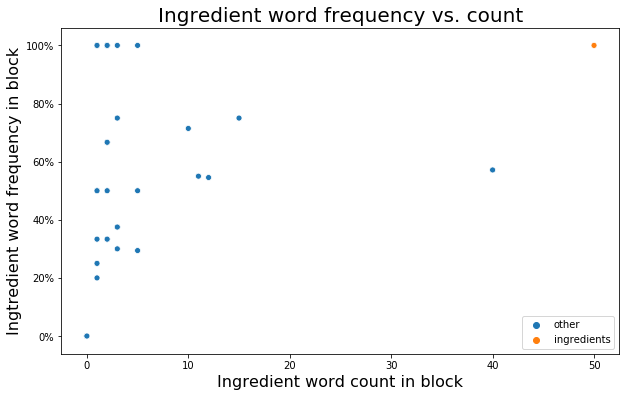

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.scatterplot(ax=ax, x=term_counts, y=term_freqs, hue=colors)
ax.set_title('Ingredient word frequency vs. count', fontsize=20)
ax.set_xlabel('Ingredient word count in block', fontsize=16)
ax.set_ylabel('Ingtredient word frequency in block', fontsize=16)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
pass

As expected, the correct ingredient list is in the top right quadrant of this representation. Should all cases yield results as sharply contrasted, we will have no difficulty in constructing an accurate functionality!

## 4.3 A difficulty arises in assessing ground truth for model validation

### Long strings are seldom strictly equal

We can compare the document ingredient list, with the one stored in the PIM system:

In [30]:
test_doc_blocks[true_idx].replace('\n', '') == df.loc[uid, "Ingrédients"]

False

Because a great deal of the current data in the PIM system has (at least once!) been manually keyed in, it is very likely that there will be an arguably high ratio of mistakes.

In [34]:
print('From pdf file: ')
print(test_doc_blocks[true_idx].replace('\n', ''))
print('--------------------------------------------------------------------------------------')
print('From PIM system:')
print(df.loc[uid, "Ingrédients"])

From pdf file: 
Ingrédients:  sirop de glucose; sucre; gélatine; dextrose; acidifiants: acide citrique, acide malique; agent d'enrobage: cire de carnauba; correcteurs d'acidité: citrate tricalcique, malate acide de sodium; arôme; concentrés de fruits et de plantes: citron, carthame, spiruline, patate douce, radis; sirop de sucre inverti; colorants: carmins, bleu patenté V, carotènes végétaux, lutéine, anthocyanes.
--------------------------------------------------------------------------------------
From PIM system:
Ingrédients: sirop de glucose, sucre, gélatine, dextrose, acidifiants: acide citrique, acide malique, agent d'enrobage: cire de carnauba, correcteurs d'acidité: citrate tricalcique, malate acide de sodium, arôme, concentrés de fruits et de plantes: citron, carthame, spiruline, patate douce, radis, sirop de sucre inverti, colorants: carmins, bleu patenté V, carotènes végétaux, lutéine, anthocyanes.


One can see that although very close, those 2 texts are somewhat different, from the punctuation marks.

### Different strategies can be undertaken to get around this difficulty

It is mandatory to compare the results of the model with the ground truth to assess the performance of the model. Some workarounds can be set up:

- Ignoring all products that do not have a strict matching block in their pdf file:
    - This will enable for a simple validation process
    - But it might dramatically decreasing the size of our dataset
    - as well as making 'short ingredient list' product overrepresented
    
    
- Defining a softer way to match texts between pdf files and PIM system data **with some text preprocessing** and filtering products that do not have a matching block
    - This will mitigate the previous drawbacks
    - But will increase complexity
    
    
- Defining a softer way to match texts between pdf files and PIM system data **by computing an edition distance** and filtering products that do not have a matching block
    - This will mitigate the previous drawbacks
    - But will increase complexity, as well as requiring to manually set up a distance threshold.
    - This could also lead to have separate pdf file blocks considered ground truth should the threshold distance be too high
    
- Considering blocks n-grams 
    - This might increase the number of 
    


### Comparison between PIM system *ground truth* with documents content

TODO !!!

## Different strategies

TODO !!!

But The similarity between the ground truth (the pdf file) and the content of the PIM system can be measured via the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance). This distance is the number of character insertions, deletions or substitutions to get from one text to the other.

If we compute this distance between the pdf file block and the PIM system content we get:

In [32]:
import jellyfish
dist = jellyfish.levenshtein_distance(test_doc_blocks[true_idx].replace('\n', ''),
                                      df.loc[uid, "Ingrédients"])
print(f'Levenshtein distance between pdf file and PIM system content is: {dist}')

Levenshtein distance between pdf file and PIM system content is: 11


We can compute this distance for each block in our pdf file, and plot it in a bar graph:

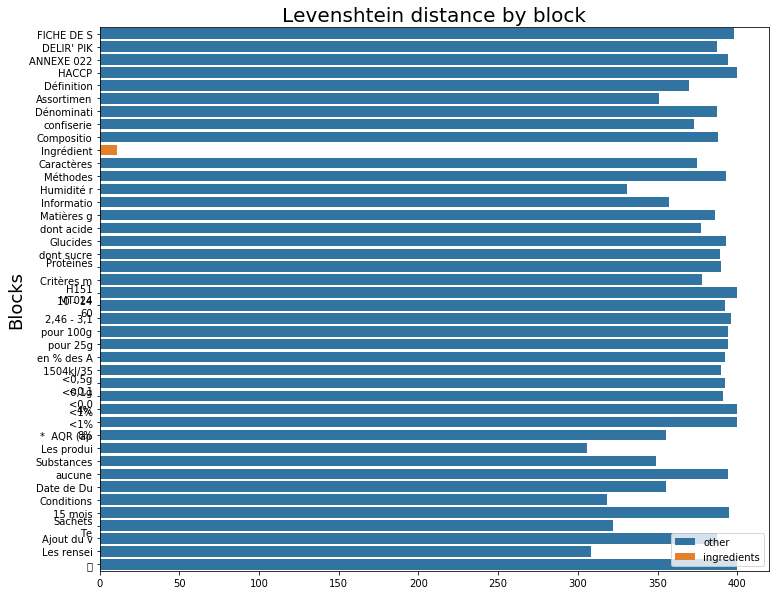

In [33]:
distances = list(map(lambda x:jellyfish.levenshtein_distance(x.replace('\n', ''), df.loc[uid, "Ingrédients"]),
                 test_doc_blocks))
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(ax=ax, x=distances, y=[block[:10] for block in test_doc_blocks], hue=colors, dodge=False)
ax.set_title('Levenshtein distance by block', fontsize=20)
ax.set_ylabel('Blocks', fontsize=18)
pass

## 4.2 Making prediction on a document